<a href="https://colab.research.google.com/github/IBM-CSM-SG/DTSA5511/blob/main/DTSA_5511_Introduction_to_Deep_Learning_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### Check GPU
!nvidia-smi
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Sat Mar 15 15:30:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   73C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU is now enabled!")
    except RuntimeError as e:
        print("Error setting GPU:", e)
else:
    print("No GPU available. Using CPU instead.")

GPU is now enabled!


In [3]:
#!pip install tensorflow

In [4]:
import shutil
import zipfile
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import roc_auc_score, confusion_matrix
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import cv2

In [5]:
print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.18.0


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**1. Brief description of the problem and data**

**Description:**

In this project, we aim to use deep learning techniques to classify and diagnose diseases affecting apple tree leaves. The dataset includes images of apple leaves with various diseases, such as rust, scab, and combinations of both, as well as healthy leaves. The objective is to develop a model that accurately identifies disease categories, distinguishes between multiple diseases on a single leaf, and handles rare classes or novel symptoms. Additionally, the model must be robust enough to deal with varying light conditions, leaf angles, and physiological stages of the leaf. The methodology will include the following stages:

* Brief Description of the Problem and Data
* Data Preprocessing and Exploratory Data Analysis (EDA)
* Model Architecture and Development
* Results and Analysis
* Conclusion

Noted: The result will be evaluated on the mean column-wise ROC AUC score.

**Data:**

The dataset for this competition contains images of apple leaves with different disease labels. The data consists of the following components:

1. train.csv: Contains labels for training, including the following columns:
   * image_id: Identifier for each image.
   * combinations, healthy, rust, scab: Target disease labels.
2. images: A folder containing the leaf images in JPG format (both training and test images).

3. test.csv: Contains the test image data with image_id and target labels for submission (combinations, healthy, rust, scab).

4. sample_submission.csv: An example file showing the required format for Kaggle submission. The file contains image_id and the predicted probabilities for each disease class.

**Files located in Google Drive:**

* train.csv: The file with image IDs and labels (combinations, healthy, rust, scab).
* test.csv: The file for the test images (with image IDs for submission).
* sample_submission.csv: The example submission format for Kaggle.
* images foler: Folder containing training and testing leaf images in JPG format.



**2. Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data**

In [7]:
# Define the path for the local upload
local_zip_path = '/content/plant-pathology-2020-fgvc7.zip'

shutil.copy('/content/drive/My Drive/DTSA5511/final/plant-pathology-2020-fgvc7.zip', local_zip_path)

'/content/plant-pathology-2020-fgvc7.zip'

In [8]:
with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/plant-pathology-2020-fgvc7/')

# Check the contents of the extracted folder
os.listdir('/content/plant-pathology-2020-fgvc7/')

['images', 'sample_submission.csv', 'train.csv', 'test.csv']

In [9]:
# Define paths
train_csv_path = '/content/plant-pathology-2020-fgvc7/train.csv'
test_csv_path = '/content/plant-pathology-2020-fgvc7/test.csv'
images_path = '/content/plant-pathology-2020-fgvc7/images/'
sample_submission_path = '/content/plant-pathology-2020-fgvc7/sample_submission.csv'

# Load the CSV files
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)
sample_submission_df = pd.read_csv(sample_submission_path)

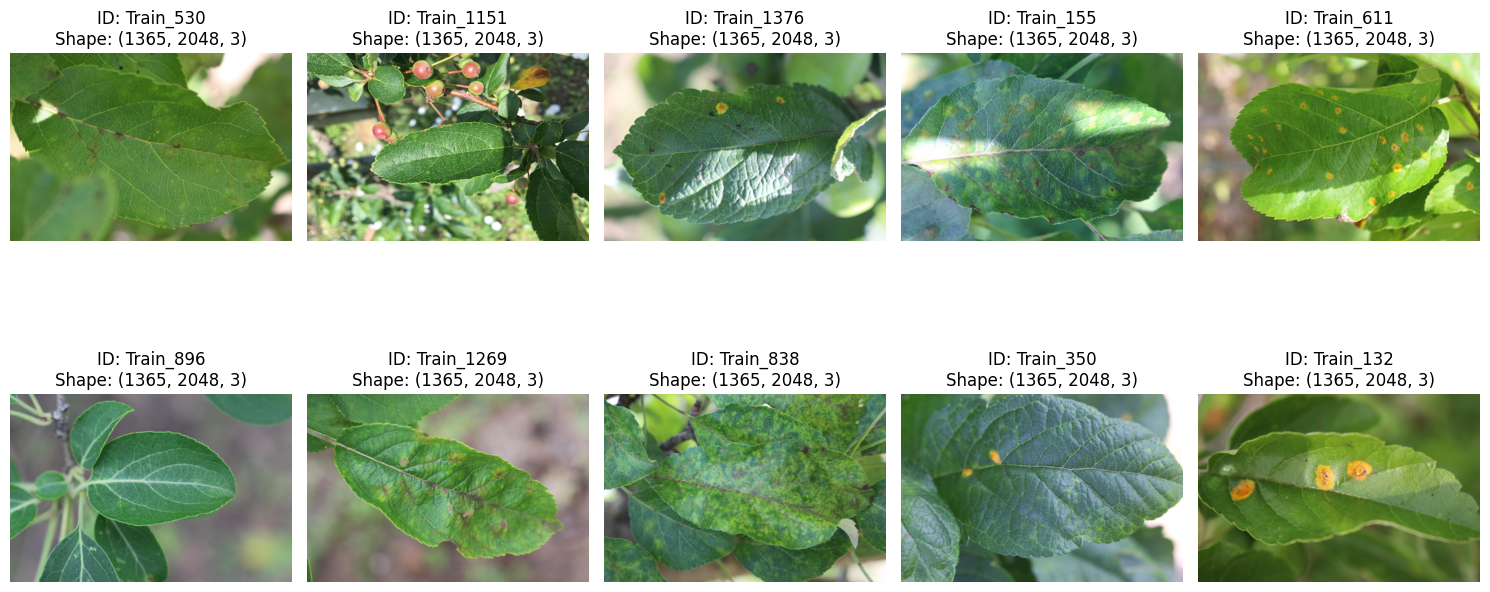

In [10]:
# Inspect images
sample_image_ids = random.sample(list(train_df['image_id']), 10)

# Plot the images
plt.figure(figsize=(15, 8))
for i, image_id in enumerate(sample_image_ids):
    image_path = os.path.join(images_path, f'{image_id}.jpg')
    img = load_img(image_path)
    img_array = np.array(img)

    image_shape = img_array.shape

    # Plot the image
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(f"ID: {image_id}\nShape: {image_shape}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [11]:
# Inspect train file
train_df = pd.read_csv(train_csv_path)
train_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   image_id           1821 non-null   object
 1   healthy            1821 non-null   int64 
 2   multiple_diseases  1821 non-null   int64 
 3   rust               1821 non-null   int64 
 4   scab               1821 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 71.3+ KB


In [13]:
train_df.describe()

,healthy,multiple_diseases,rust,scab
count,1821.000000,1821.000000,1821.000000,1821.000000
mean,0.283361,0.049973,0.341571,0.325096
std,0.450754,0.217948,0.474367,0.468539
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000


In [14]:
duplicate_train_count = train_df['image_id'].duplicated().sum()
duplicate_train_count

0

In [15]:
# Inspect test file
test_df = pd.read_csv(test_csv_path)
test_df.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


In [16]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  1821 non-null   object
dtypes: object(1)
memory usage: 14.4+ KB


In [17]:
test_df.describe()

,image_id
count,1821
unique,1821
top,Test_0
freq,1


In [18]:
duplicate_test_count = test_df['image_id'].duplicated().sum()
duplicate_test_count

0

**Note:**
* Both train.csv and test.csv do not contain any null or duplicate data.
* Each file contains 1,821 unique entries, as expected.
* The image data can be displayed, did not show any error. Each image's shape is (1365,2048,3)

**3. Model Architecture and Development**

Data Processing - Resize Images & Normalize Images

In [19]:
# Resize and normalize the images
def preprocess_images(image_ids, image_size=(256, 256)):
    images = []
    for image_id in image_ids:
        image_path = os.path.join(images_path, f'{image_id}.jpg')
        img = load_img(image_path, target_size=image_size)
        img_array = img_to_array(img) / 255.0
        images.append(img_array)
    return np.array(images)

In [20]:
# Data Processing
y = train_df[['healthy', 'multiple_diseases', 'rust', 'scab']].values
y = np.argmax(y, axis=1)

y = to_categorical(y, num_classes=4)
X = preprocess_images(train_df['image_id'])

In [21]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (1456, 256, 256, 3)
Validation data shape: (365, 256, 256, 3)


Build Simple CNN model as a baseline model
* Define Architecture
* Comply model
* Model summary
* Train model
* Plot and validate
* Evaluations

In [22]:
# Build the simple CNN model
model_simple_cnn = models.Sequential([
    # First layer
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2, 2)),

    # Second layer
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Third  layer
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flatten the output
    layers.Flatten(),

    # Fully connected layer
    layers.Dense(128, activation='relu'),

    # Output layer with 4 classes
    layers.Dense(4, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
# Compile
model_simple_cnn.compile(optimizer='adam',
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

In [24]:
# Display the summary
model_simple_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      14,745,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,839,492 (56.61 MB)

 Trainable params: 14,839,492 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Train the model
history_simple_cnn = model_simple_cnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 16s 203ms/step - accuracy: 0.3300 - loss: 1.7261 - val_accuracy: 0.3699 - val_loss: 1.2259
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.4330 - loss: 1.1991 - val_accuracy: 0.4466 - val_loss: 1.1968
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.5017 - loss: 1.1458 - val_accuracy: 0.5288 - val_loss: 1.1211
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.5998 - loss: 0.9742 - val_accuracy: 0.5726 - val_loss: 1.1128
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.6996 - loss: 0.7996 - val_accuracy: 0.5918 - val_loss: 1.0544
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.8690 - loss: 0.4066 - val_accuracy: 0.6137 - val_loss: 1.1037
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.9402 - loss: 0.2142 - val_accuracy: 0.6301 - val_loss: 1.3467
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.9784 - loss: 0.0895 - val_accuracy: 0.6301 -

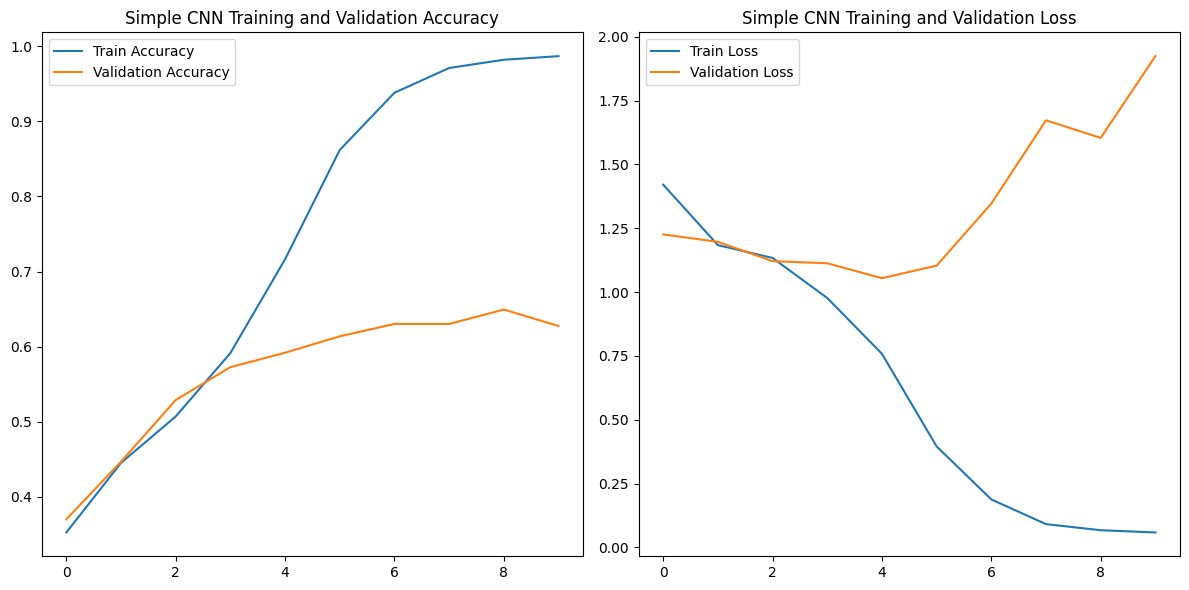

In [26]:
# Plot training and validation accuracy/loss for the simple CNN model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_simple_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_simple_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Simple CNN Training and Validation Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_simple_cnn.history['loss'], label='Train Loss')
plt.plot(history_simple_cnn.history['val_loss'], label='Validation Loss')
plt.title('Simple CNN Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

**Analysis**:

* **Training Accuracy vs. Validation Accuracy**: Training accuracy is increasing steadily, indicating that the model is learning the training data. Validation accuracy, however, is not improving much and is even slightly decreasing after a certain number of epochs. This suggests that the model is overfitting to the training data. Overfitting happens when the model memorizes the training data but fails to generalize well to unseen data.

* **Training Loss vs. Validation Loss**: Training loss is decreasing steadily, which means the model is fitting the training data well.
Validation loss, on the other hand, is increasing after a few epochs, which further supports the idea of overfitting.

In [27]:
# Make predictions
X_test = preprocess_images(test_df['image_id'])
predictions = model_simple_cnn.predict(X_test)
predictions[:5]

57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step


array([[7.4386162e-01, 3.5321380e-03, 2.5213122e-01, 4.7502443e-04],
       [1.2570106e-06, 2.6363198e-11, 9.9998152e-01, 1.7121065e-05],
       [6.0162759e-01, 3.8430787e-04, 3.3692420e-03, 3.9461890e-01],
       [6.0474938e-01, 2.2877281e-04, 1.5642086e-01, 2.3860103e-01],
       [5.9030350e-12, 2.0885765e-11, 1.0000000e+00, 4.7871365e-09]],
      dtype=float32)

In [28]:
# Save resutls
submission = pd.DataFrame(predictions, columns=['healthy', 'multiple_diseases', 'rust', 'scab'])
submission['image_id'] = test_df['image_id']
submission = submission[['image_id', 'healthy', 'multiple_diseases', 'rust', 'scab']]

submission_path = '/content/submission.csv'
submission.to_csv(submission_path, index=False)

In [29]:
from google.colab import files
files.download(submission_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model_simple_cnn.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6104 - loss: 2.1920
Validation Loss: 1.924086332321167
Validation Accuracy: 0.6273972392082214


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


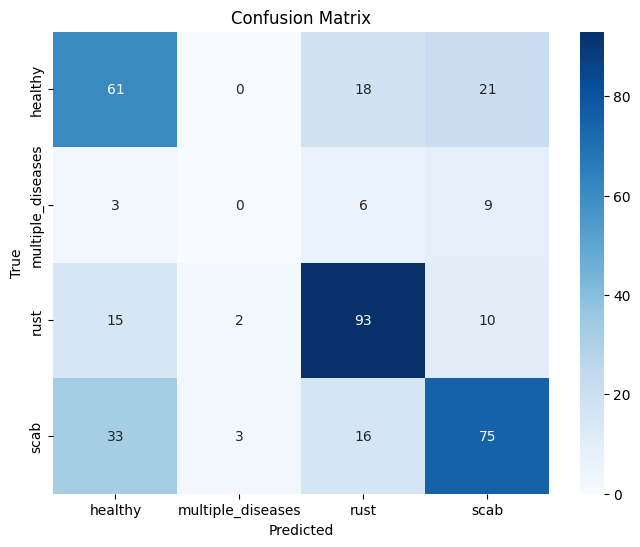

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_val_pred = model_simple_cnn.predict(X_val)
y_val_pred_class = np.argmax(y_val_pred, axis=1)
y_val_class = np.argmax(y_val, axis=1)
cm = confusion_matrix(y_val_class, y_val_pred_class)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['healthy', 'multiple_diseases', 'rust', 'scab'],
            yticklabels=['healthy', 'multiple_diseases', 'rust', 'scab'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [32]:
from sklearn.metrics import roc_auc_score
y_val_pred_prob = model_simple_cnn.predict(X_val)

roc_auc = roc_auc_score(y_val, y_val_pred_prob, average='macro', multi_class='ovr')
print(f"ROC AUC Score: {roc_auc}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
ROC AUC Score: 0.7842396787335746


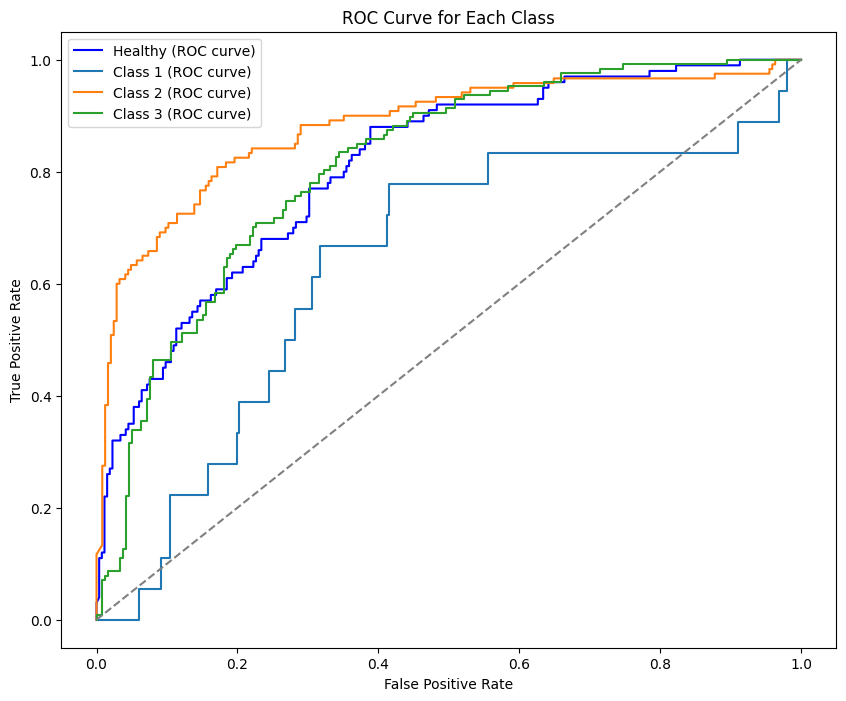

In [33]:
from sklearn.metrics import roc_curve

# Get the false positive rate, true positive rate, and thresholds
fpr, tpr, _ = roc_curve(y_val[:, 0], y_val_pred_prob[:, 0])  # For class 0 (healthy)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label='Healthy (ROC curve)', color='blue')

for i in range(1, y_val.shape[1]):
    fpr, tpr, _ = roc_curve(y_val[:, i], y_val_pred_prob[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (ROC curve)')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc='best')
plt.show()

**Evaluation and Results analyis:**

* Model Performance: The model has a validation accuracy of 62.73% and a ROC AUC score of 0.7842, indicating moderate performance with room for improvement.
* Confusion Matrix Insights: The model performs well at predicting some classes (e.g., rust), but struggles to distinguish between similar classes, particularly healthy vs. scab.
* Improvement Areas: The validation loss of 1.92 suggests that the model could benefit from more training, advanced architectures, or fine-tuning.

Next Steps: I will enhance simple CNN model to reduce our fitting by apply dropout, early stopping, reduce learning rate on Plateau.

Enhance CNN Model with dropout, apply EarlyStopping and ReduceLROnPlateau
* Enhance model with dropout
* EarlyStopping and ReduceLROnPlateau
* Train
* Evaluate

In [34]:
# Build the enhanced CNN model
model_enhanced_cnn = models.Sequential([

    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    layers.Dense(128, activation='relu', kernel_regularizer='l2'),

    layers.Dropout(0.5),

    layers.Dense(4, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [35]:
# Compile
model_enhanced_cnn.compile(optimizer='adam',
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

In [36]:
# Model summary
model_enhanced_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      14,745,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,839,492 (56.61 MB)

 Trainable params: 14,839,492 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Define EarlyStopping and ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [38]:
# Train model
history_enhanced_cnn = model_enhanced_cnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 0.3124 - loss: 2.8705 - val_accuracy: 0.3288 - val_loss: 1.4425 - learning_rate: 0.0010
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.3492 - loss: 1.3934 - val_accuracy: 0.4110 - val_loss: 1.2702 - learning_rate: 0.0010
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.3531 - loss: 1.3123 - val_accuracy: 0.3397 - val_loss: 1.2810 - learning_rate: 0.0010
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.3143 - loss: 1.2953 - val_accuracy: 0.3753 - val_loss: 1.2628 - learning_rate: 0.0010
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.3900 - loss: 1.2907 - val_accuracy: 0.4849 - val_loss: 1.2312 - learning_rate: 0.0010
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.4834 - loss: 1.2529 - val_accuracy: 0.5616 - val_loss: 1.2315 - learning_rate: 0.0010
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.5553 - loss: 1.2440 - val_a

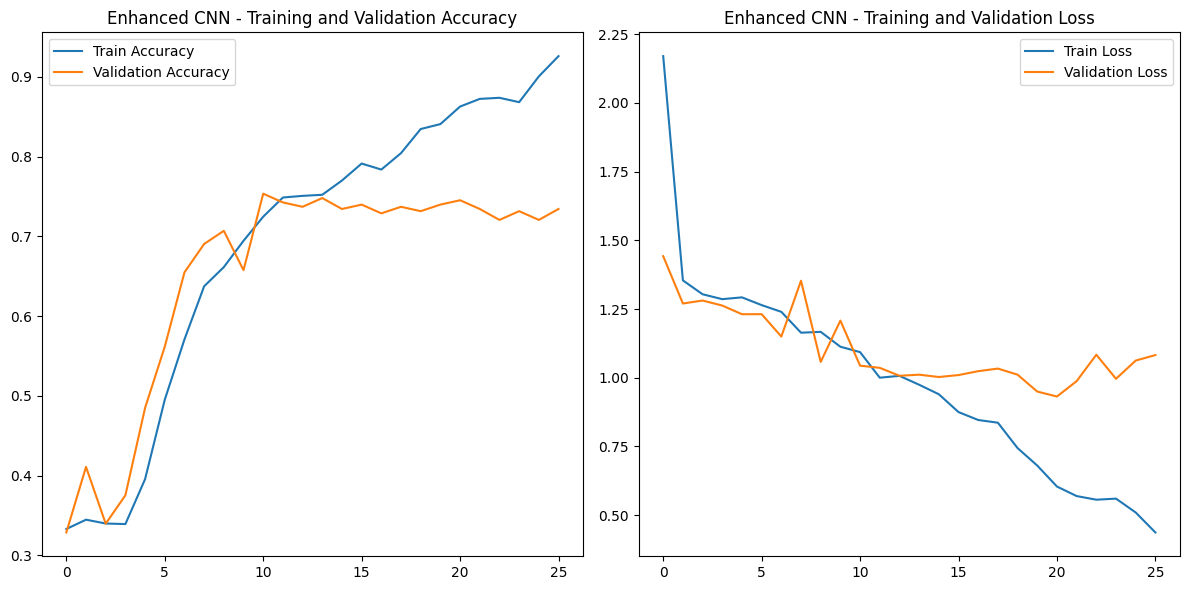

In [39]:
# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_enhanced_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_enhanced_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Enhanced CNN - Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_enhanced_cnn.history['loss'], label='Train Loss')
plt.plot(history_enhanced_cnn.history['val_loss'], label='Validation Loss')
plt.title('Enhanced CNN - Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

**Analysis:**

The Enhanced CNN appears to be a better comparing to simple CNN model, particularly in the initial training stages. However, both models show signs of overfitting - we can enhance in the future.

In [40]:
# Make predictions
X_test = preprocess_images(test_df['image_id'])
predictions = model_enhanced_cnn.predict(X_test)
print(predictions[:5])

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
[[7.83467622e-05 4.11368860e-03 9.95718420e-01 8.95606936e-05]
 [2.52315458e-05 1.51453982e-03 9.98369753e-01 9.05330016e-05]
 [1.13087445e-01 1.33862020e-02 6.05404703e-03 8.67472291e-01]
 [5.37534475e-01 2.72553563e-02 2.25159246e-02 4.12694275e-01]
 [1.49606471e-18 8.06124412e-09 1.00000000e+00 5.99491804e-16]]


In [41]:
# Save results
submission = pd.DataFrame(predictions, columns=['healthy', 'multiple_diseases', 'rust', 'scab'])
submission['image_id'] = test_df['image_id']
submission = submission[['image_id', 'healthy', 'multiple_diseases', 'rust', 'scab']]

submission_path = '/content/submission.csv'
submission.to_csv(submission_path, index=False)

In [42]:
# Download  submission file
from google.colab import files
files.download(submission_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [43]:
# Evaluate model
val_loss, val_accuracy = model_enhanced_cnn.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7442 - loss: 0.9288
Validation Loss: 0.9316735863685608
Validation Accuracy: 0.7452054619789124


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


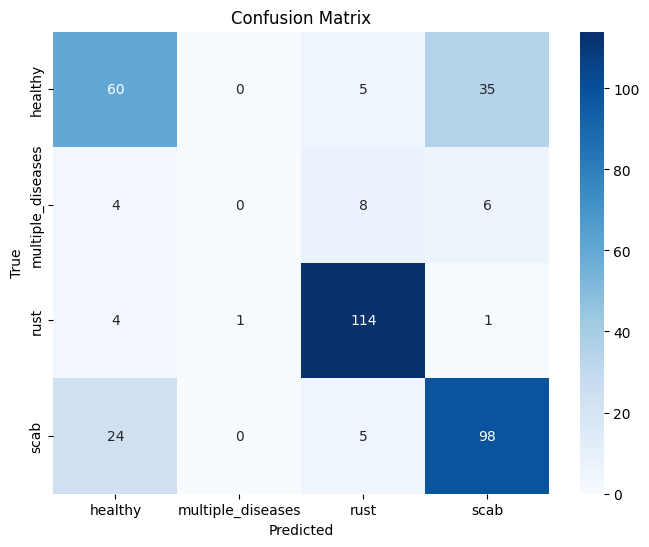

In [44]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_val_pred = model_enhanced_cnn.predict(X_val)
y_val_pred_class = np.argmax(y_val_pred, axis=1)
y_val_class = np.argmax(y_val, axis=1)
cm = confusion_matrix(y_val_class, y_val_pred_class)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['healthy', 'multiple_diseases', 'rust', 'scab'],
            yticklabels=['healthy', 'multiple_diseases', 'rust', 'scab'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [45]:
# ROC AUC
from sklearn.metrics import roc_auc_score

y_val_pred_prob = model_enhanced_cnn.predict(X_val)
roc_auc = roc_auc_score(y_val, y_val_pred_prob, average='macro', multi_class='ovr')
print(f"ROC AUC Score: {roc_auc}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
ROC AUC Score: 0.843405589779668


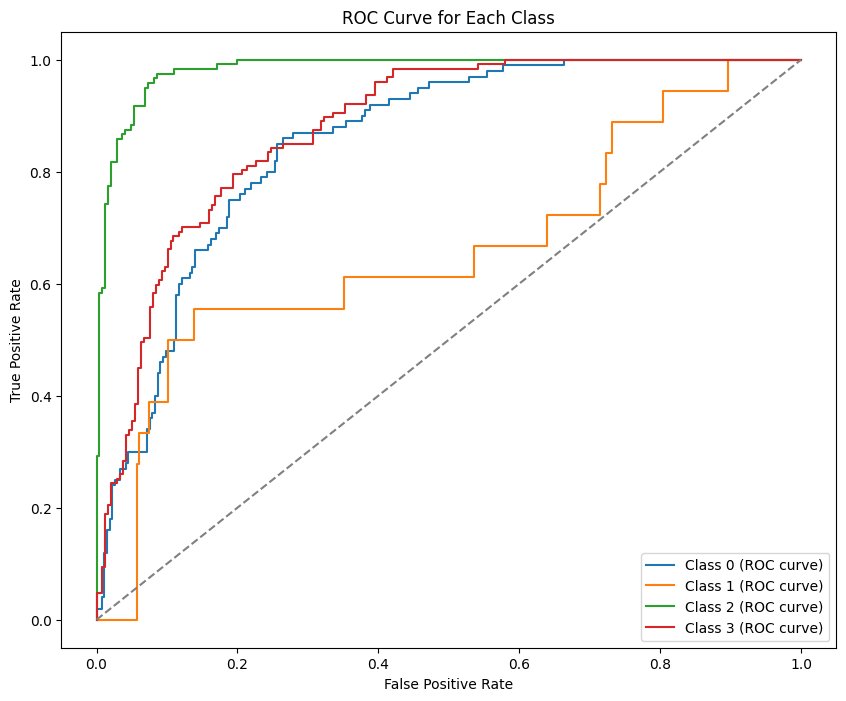

In [46]:
# ROC Curve
from sklearn.metrics import roc_curve

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(y_val.shape[1]):
    fpr, tpr, _ = roc_curve(y_val[:, i], y_val_pred_prob[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (ROC curve)')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc='best')
plt.show()

**Evaluation and Results Analysis:**

* **Model Performance**: The enhanced model achieved a validation accuracy of 74.5% and a ROC AUC score of 0.8434, indicating strong performance, with room for further improvement. The model shows a good ability to distinguish between classes but could still benefit from further tuning.

* **Confusion Matrix**: The model performs well in identifying healthy and rust classes, but struggles more with distinguishing between scab and multiple diseases. The confusion matrix shows that misclassifications mostly occur between similar classes, suggesting that the model could benefit from more refined training or feature extraction.

* **Improvement Areas**: Despite the reasonable performance, the validation loss of 1.03 suggests that the model may still be overfitting and could benefit from additional training, more regularization, or data augmentation. Fine-tuning the architecture and adding more advanced regularization techniques could help the model generalize better.

**Conclusion:**

* The simple CNN model achieved 62.73% validation accuracy and ROC AUC score of 0.7842, with moderate performance. It performed well for certain classes but struggled with distinguishing similar ones like healthy vs. scab. The validation loss of 1.92 indicated that the model could benefit from more training and fine-tuning.

* The enhanced CNN model improved performance with 74.5% validation accuracy and ROC AUC score of 0.8434, addressing some of the issues from the simple model, particularly in the validation metrics.
Model Performance: The enhanced model showed better accuracy and ROC AUC scores, indicating better overall performance. It still struggled with classifying scab, but improvements were evident compared to the simple CNN.

* To further improve, we should explore more advanced architectures, increase regularization, and implement more data augmentation techniques.

In conclusion, the enhanced CNN model provides a significant improvement over the simple CNN, with better accuracy and generalization, though further refinements are needed to optimize performance.